In [1]:
!nvidia-smi

Mon May 15 14:55:21 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti      On | 00000000:01:00.0 Off |                  N/A |
|  0%   35C    P8               20W / 310W|    567MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os

###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
###
from tqdm import tqdm
from sklearn.model_selection import train_test_split
#
from PIL import Image
#
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from torch import nn
###
from transformers import CLIPModel, CLIPConfig, CLIPVisionModel
#from transformers import AutoModel, AutoTokenizer
#from transformers import TrainingArguments, Trainer
from transformers import default_data_collator

2023-05-15 14:55:23.683889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset

In [ ]:
import re
from nltk.tokenize import sent_tokenize

In [ ]:
### MIMIC Meta Data

In [ ]:
folder = "/media/andrew/HD-GDU3/498/"
meta_data = "cleaned_single_image_only_relevant_headings_metadata.csv"
md_location = folder + meta_data
meta_reports = pd.read_csv(md_location)
sample = meta_reports.head()
sample

In [ ]:
for observation in range(0,len(sample)):
    container = []
    for cat in categories:
        if np.isnan(sample[cat][observation]) or sample[cat][observation] < 0:
            pass
        elif sample[cat][observation] > 0:
            container.append(cat)
        elif sample[cat][observation] == 0:
            container.append(f'Not {cat}')
    print (container)
    print ("-----")
        

In [ ]:
list(meta_reports)

In [ ]:
## Mimic Reports

In [ ]:
folder = "/media/andrew/HD-GDU3/498/"
medical_reports = "cleaned_single_image_only_relevant_headings2.csv"
#dataset = "output.csv"
location = folder + medical_reports

In [ ]:
reports = pd.read_csv(location)
reports

In [ ]:
## Impression, Finding, and WetRead are what we are looking for.
## Create Sentence Vectors for each of the sections, stripping out times.

In [ ]:
headings = ['FINDINGS:', 'IMPRESSION:', 'WET READ:']

In [ ]:
def preptext(x, db, feature, exclude):
    text = db[feature][x]
    for k in exclude:
        m = text.replace(k, '')
    m = m.replace("AM ", '')
    m = m.replace("PM ", '')
    m = re.sub(r'\b[A-Z]+: ', '', m)
    m = re.sub(r'\d+.', '', m).strip().lower()
    m = re.sub(' +', ' ', m)
    
    return (m)

In [ ]:
def create_vectors(x, db = sample, headings = headings):
    i = 0
    state = [0,0,0]
    for feature in headings:
        if isinstance(db[feature][x], str):
            state[i] = 1
            print (sent_tokenize(preptext(x, db = db, feature = feature, exclude = headings)))
        i += 1
    
    return (state)

In [ ]:
def combine_texts(observation, db, headings=headings, as_sentences = False):
    i = 0
    output = []
    state = [False, False, False]
    for feature in headings:
        if isinstance(db[feature][observation], str):
            state[i] = True
        i += 1
    
    if state[0] and state[1]: 
        for feature in ['FINDINGS:', 'IMPRESSION:']:
            output = output + sent_tokenize(preptext(observation, db = db, feature = feature, exclude = headings))
    else:
        for feature in headings:
            if isinstance(db[feature][observation], str):
                output = output + sent_tokenize(preptext(observation, db = db, feature = feature, exclude = headings))
    
    if not as_sentences:
        output = ' '.join(output)
        
    return output

In [ ]:
combine_texts(268, db=reports, as_sentences=False)

In [ ]:
## Create Training Set

In [ ]:
# Load Image Set

In [ ]:
def build_set(csv, subfolder, head=False, base_folder="/media/andrew/HD-GDU3/498/"):
    folder = base_folder + subfolder
    dataset = csv
    location = folder + dataset
    db = pd.read_csv(location)
    
    if head == True:
        db = db.head()
    
    return db

In [ ]:
def gen_name(observation, db):
    subject_id = db['subject_id'][observation]
    study_id = db['study_id'][observation]
    dicom_id = db['dicom_id'][observation]
    new_name = f'{subject_id}_{study_id}_{dicom_id}.jpg'
    
    return new_name

In [ ]:
def create_record(location, image, caption):
    record = pd.DataFrame({
        'caption':caption, 
        'image':location+image
        }, index=[0])
    return record

In [ ]:
def create_image_text_pairs(image_db, text_db, image_location, by_sentence=False, debug=False):
    
    container  = pd.DataFrame(columns=['caption','image'])
    images = image_db
    texts = text_db
    
    for observation in range(0, len(images.study_id)):
        if by_sentence:
            current_study_id = texts['study_id'][observation]
            if debug: print (current_study_id)
            try:
                statements = len(combine_texts(texts.loc[texts['study_id'] == images['study_id'][observation]].index[0], db=texts, as_sentences=by_sentence))
            except:
                if debug: print (f'Text not found for image {current_study_id}')
            if debug: print (statements)
            for i in range(0, statements):
                try:
                    record = create_record(
                        location = image_location,
                        caption = combine_texts(texts.loc[texts['study_id'] == images['study_id'][observation]].index[0], db=texts, as_sentences=by_sentence)[i],
                        image =  str(gen_name(observation, db = images))
                    )
                    container = pd.concat([container, record],ignore_index=True)
                    if debug: print ('Record Added')
                except:
                    pass
        else:
            try:
                record = create_record(
                    location = image_location,
                    caption = combine_texts(texts.loc[texts['study_id'] == images['study_id'][observation]].index[0], db=texts, as_sentences=by_sentence),
                    image =  str(gen_name(observation, db = images))
                )
                container = pd.concat([container, record],ignore_index=True)
                if debug: print ('Record Added')
            except:
                pass
        if debug: print ('---------')
    return container

In [ ]:
## Create Training and Validation Set

In [ ]:
training = create_image_text_pairs(
    image_db = build_set(csv='train.csv', subfolder='train/', head=False),
    text_db = reports,
    image_location = folder + 'train/train_resized/resized/',
    by_sentence = True
    )
training.dropna().to_csv('training.csv', index=False)
training

In [ ]:
total  = len(training)
print (f'Training: {len(training)} {len(training)/total}')
print ("Max size",len(training['caption'].max()))

In [ ]:
training = create_image_text_pairs(
    image_db = build_set(csv='train.csv', subfolder='train/', head=False),
    text_db = reports,
    image_location = folder + 'train/train_resized/resized/'
    )
training.dropna().to_csv('training.csv', index=False)
training

In [ ]:
validation = create_image_text_pairs(
    image_db = build_set(csv='validation.csv', subfolder='validation/', head=False),
    text_db = reports,
    image_location = folder + 'validation/validation_resized/validation/'
    )
validation.dropna().to_csv('validation.csv', index=False)
validation

In [ ]:
## Create Test Set

In [ ]:
test = create_image_text_pairs(
    image_db = build_set(csv='test.csv', subfolder='test/', head=False),
    text_db = reports,
    image_location = folder + 'test/test_resized/resized/'
    )
test.dropna().to_csv('test.csv', index=False)
test

In [ ]:
total  = len(training) + len(validation) + len(test)
print (f'Training: {len(training)} {len(training)/total}')
print (f'Validation: {len(validation)} {len(validation)/total}')
print (f'Test: {len(test)} {len(test)/total}')

# Tensorboard

In [4]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Training

In [5]:
from transformers import TrainingArguments, AutoTokenizer, CLIPFeatureExtractor

In [6]:
#TEXT_MODEL = 'm3hrdadfi/roberta-zwnj-wnli-mean-tokens'
#TEXT_MODEL = 'bert-base-uncased'
#TEXT_MODEL = "roberta-base"
#TEXT_MODEL = "bert-base-uncased"
TEXT_MODEL = "emilyalsentzer/Bio_ClinicalBERT"
#TEXT_MODEL = "openai/clip-vit-base-patch32"
#TEXT_MODEL = "openai/clip-vit-base-patch16"
#IMAGE_MODEL = "openai/clip-vit-large-patch14"
IMAGE_MODEL = 'openai/clip-vit-base-patch32'

In [7]:
BATCH_SIZE = 8
GRADIENT_ACCUMULATION = 4
RUN_NAME = 'clip-checkpoints-sentences-bioclinbert-1'
BASE_DIR = '/media/andrew/HD-GDU3/498/'
OUTPUT_DIR = BASE_DIR + RUN_NAME
LEARNING_RATE = 3e-6 #3e-5
WEIGHT_DECAY = 0.01 #0.003
OPTIMIZER = "AdamW"
CALLBACKS = None
IMAGE_SIZE = 224
MAX_LEN = 80
MEAN = torch.tensor([0.42695613, 0.42695613, 0.42695613]) #Image Mean
STD = torch.tensor([0.31928246, 0.31928246, 0.31928246]) #Image STD

In [8]:
from transformers import CLIPFeatureExtractor

In [9]:
vision_preprocessor = CLIPFeatureExtractor.from_pretrained(IMAGE_MODEL)

In [10]:
from transformers import CLIPTokenizer
tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)
#tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [11]:
from clip_classes import CLIPDataset

In [12]:
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="steps",
    save_strategy="epoch",
    eval_steps=1000,
    logging_steps=10,
    learning_rate=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY, 
    warmup_steps=100,
    fp16=False,
    prediction_loss_only=True,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION, #1
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,
    report_to='none'
)

## Utils: some helper functions
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/training/utils.py

In [13]:
import helper

In [14]:
from clip_functions import clip_wrapper_creator

## DataModule: datasets and dataloaders
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/training/data.py

## Model: define vision and text encoder
https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/training/model.py

In [15]:
from transformers import CLIPTextModel

In [16]:
DATA_FILE = 'training.csv'
TEST_SIZE = 0.05

In [17]:
from torch.utils.data import Dataset

class CLIPDataset(Dataset):
    def __init__(self, image_paths: list, text: list, mode: str = 'train'):
        self.image_paths = image_paths
        self.tokens = tokenizer(text, 
                                padding = 'max_length',
                                max_length = MAX_LEN, 
                                truncation = True
                               )

        if mode == 'train':
            self.augment = transforms.Compose([
                #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                #transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])
        elif mode == 'test':
            self.augment = transforms.Compose([
                #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])

    def __getitem__(self, idx):
        token = self.tokens[idx]
        return {'input_ids': token.ids, 'attention_mask': token.attention_mask,
                'pixel_values': self.augment(Image.open(self.image_paths[idx]).convert('RGB'))}

    def __len__(self):
        return len(self.image_paths)

In [18]:
df = pd.read_csv(DATA_FILE).dropna()
#test_df = pd.read_csv('test.csv').dropna()
#validate_df = pd.read_csv('validate.csv').dropna()

train_df, test_df = train_test_split(df, test_size=TEST_SIZE)
train_ds = CLIPDataset(image_paths=train_df.image.tolist(),text=train_df.caption.tolist(), mode='train')
test_ds = CLIPDataset(image_paths=test_df.image.tolist(),text=test_df.caption.tolist(), mode='test')
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,collate_fn=default_data_collator)

In [19]:
def show_data(batch, idx=0):
    # show image
    img = batch['pixel_values'][idx].permute(1, 2, 0)
    img = STD * img + MEAN
    print('Image shape: ', img.shape)
    plt.imshow(img)
    # show text
    text = tokenizer.decode(batch['input_ids'][idx],  skip_special_tokens=True)
    print('Text: ', text)

torch.Size([8, 80])
torch.Size([8, 3, 224, 224])
Image shape:  torch.Size([224, 224, 3])
Text:  again seen top normal to possibly minimally enlarged cardiac silhouette given ap technique ; as mentioned on the prior study cardiac silhouette size warrants further evaluation if not performed since the prior study.


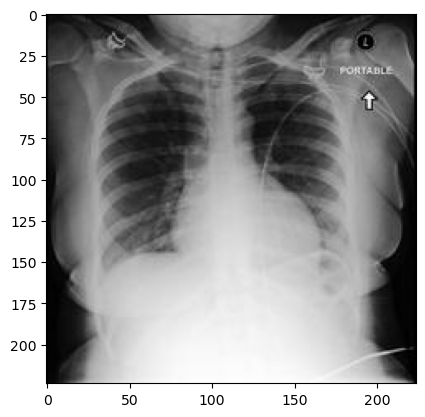

In [20]:
for item in train_dl:
    print(item['input_ids'].shape)
    print(item['pixel_values'].shape)
    break
show_data(item)

In [21]:
vision_encoder = CLIPVisionModel.from_pretrained(IMAGE_MODEL)
#config = CLIPConfig.from_pretrained("openai/clip-vit-base-patch16")
#vision_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16", config=config.vision_config)

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['logit_scale', 'text_model.encoder.layers.5.mlp.fc2.weight', 'text_model.encoder.layers.10.mlp.fc2.bias', 'text_model.encoder.layers.7.self_attn.q_proj.bias', 'text_model.encoder.layers.8.layer_norm2.weight', 'text_model.encoder.layers.9.mlp.fc2.weight', 'text_model.encoder.layers.4.mlp.fc2.bias', 'text_model.encoder.layers.2.layer_norm1.bias', 'text_model.encoder.layers.8.self_attn.q_proj.weight', 'text_model.encoder.layers.4.self_attn.v_proj.bias', 'text_model.encoder.layers.11.layer_norm2.bias', 'text_model.encoder.layers.4.self_attn.out_proj.bias', 'text_model.encoder.layers.10.self_attn.q_proj.weight', 'text_model.encoder.layers.9.self_attn.v_proj.bias', 'text_model.encoder.layers.1.mlp.fc1.bias', 'text_model.encoder.layers.3.mlp.fc1.bias', 'text_model.encoder.layers.4.self_attn.q_proj.weight', 'text_model.encoder.layers.0.self_attn.v_proj.weight', 'text_model.enc

In [22]:
text_encoder = CLIPTextModel.from_pretrained(TEXT_MODEL)
#text_encoder = BertModel.from_pretrained("bert-base-uncased")

You are using a model of type bert to instantiate a model of type clip_text_model. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing CLIPTextModel: ['bert.encoder.layer.8.attention.self.key.weight', 'bert.encoder.layer.7.attention.self.query.bias', 'bert.encoder.layer.11.intermediate.dense.bias', 'bert.encoder.layer.5.attention.self.value.weight', 'bert.encoder.layer.11.output.dense.bias', 'bert.encoder.layer.2.output.dense.weight', 'bert.encoder.layer.7.attention.self.value.weight', 'bert.encoder.layer.9.attention.output.dense.weight', 'bert.encoder.layer.9.attention.output.dense.bias', 'bert.encoder.layer.11.attention.self.value.bias', 'bert.encoder.layer.11.attention.self.query.weight', 'bert.encoder.layer.1.attention.self.value.bias', 'bert.encoder.layer.7.output.dense.bias', 'cls.predictions.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.

In [23]:
def clip_wrapper_creator():
    """create a dummy CLIPModel to wrap text and vision encoders in order to use CLIPTrainer"""
    config = {'num_hidden_layers': 0,
              'max_position_embeddings': 0,
              'vocab_size': 0,
              'hidden_size': 1,
              'patch_size': 1,
              }

    #DUMMY_CONFIG = CLIPConfig(text_config_dict=config,vision_config_dict=config)
    DUMMY_CONFIG = CLIPConfig(
        text_config_dict = config,
        vision_config_dict = config
    )

    clip = CLIPModel(config=DUMMY_CONFIG)

    # convert projectors to Identity
    clip.text_projection = nn.Identity()
    clip.visual_projection = nn.Identity()

    return clip


In [24]:
#text_encoder = AutoModel.from_pretrained(TEXT_MODEL)
#text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32')

clip = clip_wrapper_creator()
clip.text_model = text_encoder
clip.vision_model = vision_encoder

In [25]:
text_encoder.config.hidden_size

768

In [26]:
vision_encoder.config.hidden_size

768

In [27]:
assert text_encoder.config.hidden_size == vision_encoder.config.hidden_size

In [28]:
if __name__ == '__main__':
    out = clip(input_ids=item['input_ids'],
               attention_mask=item['attention_mask'],
               pixel_values=item['pixel_values'],
               return_loss=True)

    print('text and image embeddings: ',
          out.text_embeds.shape, out.image_embeds.shape)
    print('loss: ', out.loss)
    del out, item

text and image embeddings:  torch.Size([8, 768]) torch.Size([8, 768])
loss:  tensor(2.0901, grad_fn=<DivBackward0>)


## Trainer: train using huggingface trainer
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/training/train.py

In [29]:
from clip_classes import CLIPTrainer
from transformers.integrations import TensorBoardCallback

In [ ]:
def train_model():
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    helper.clear_gpu()
    args.dataloader_num_workers = helper.optimal_workers()
    trainer = CLIPTrainer(clip, args,
                          train_dataset=train_ds,
                          eval_dataset=test_ds,
                          callbacks = [TensorBoardCallback]
                         )

    trainer.train()

train_model()

    # save pretrained models
    # clip.text_model.save_pretrained('radCLIP')
    # tokenizer.save_pretrained('radCLIP')
    # clip.vision_model.save_pretrained('radCLIP')
    # vision_preprocessor.save_pretrained('radCLIP')

/home/andrew/miniconda3/envs/CLIP_demo/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 300413
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 93880
  Number of trainable parameters = 195174145


Step,Training Loss,Validation Loss
1000,2.023200,2.028349
2000,1.972300,1.977598
3000,1.911300,1.938011
4000,1.932300,1.914436
5000,1.898400,1.893815
6000,1.843800,1.874476
7000,1.846600,1.864647
8000,1.817300,1.843327
9000,1.842800,1.841940
10000,1.782400,1.829314


***** Running Evaluation *****
  Num examples = 15812
  Batch size = 8
***** Running Evaluation *****
  Num examples = 15812
  Batch size = 8
***** Running Evaluation *****
  Num examples = 15812
  Batch size = 8
***** Running Evaluation *****
  Num examples = 15812
  Batch size = 8
***** Running Evaluation *****
  Num examples = 15812
  Batch size = 8
***** Running Evaluation *****
  Num examples = 15812
  Batch size = 8
***** Running Evaluation *****
  Num examples = 15812
  Batch size = 8
***** Running Evaluation *****
  Num examples = 15812
  Batch size = 8
***** Running Evaluation *****
  Num examples = 15812
  Batch size = 8
Saving model checkpoint to /media/andrew/HD-GDU3/498/clip-checkpoints-sentences-bioclinbert-1/checkpoint-9388
Configuration saved in /media/andrew/HD-GDU3/498/clip-checkpoints-sentences-bioclinbert-1/checkpoint-9388/config.json
Model weights saved in /media/andrew/HD-GDU3/498/clip-checkpoints-sentences-bioclinbert-1/checkpoint-9388/pytorch_model.bin
***** Run

# Demo

## Utils: demo utils
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/application/utils.py

In [ ]:
class VisionDataset(Dataset):
    preprocess = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ])

    def __init__(self, image_paths: list):
        self.image_paths = image_paths

    def __getitem__(self, idx):
        return self.preprocess(Image.open(self.image_paths[idx]).convert('RGB'))

    def __len__(self):
        return len(self.image_paths)


class TextDataset(Dataset):
    def __init__(self, text: list, tokenizer, max_len):
        self.len = len(text)
        self.tokens = tokenizer(text, padding='max_length',
                                max_length=max_len, truncation=True)

    def __getitem__(self, idx):
        token = self.tokens[idx]
        return {'input_ids': token.ids, 'attention_mask': token.attention_mask}

    def __len__(self):
        return self.len

## CLIPDemo
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/application/main.py

In [ ]:
import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import default_data_collator


class CLIPDemo:
    def __init__(self, vision_encoder, text_encoder, tokenizer,
                 batch_size: int = 32, max_len: int = 32, device='cuda'):
        """ Initializes CLIPDemo
            it has the following functionalities:
                image_search: Search images based on text query
                zero_shot: Zero shot image classification
                analogy: Analogies with embedding space arithmetic.

            Args:
            vision_encoder: Fine-tuned vision encoder
            text_encoder: Fine-tuned text encoder
            tokenizer: Transformers tokenizer
            device (torch.device): Running device
            batch_size (int): Size of mini-batches used to embeddings
            max_length (int): Tokenizer max length

            Example:
            >>> demo = CLIPDemo(vision_encoder, text_encoder, tokenizer)
            >>> demo.compute_image_embeddings(test_df.image.to_list())
            >>> demo.image_search('یک مرد و یک زن')
            >>> demo.zero_shot('./workers.jpg')
            >>> demo.anology('./sunset.jpg', additional_text='دریا')
        """
        self.vision_encoder = vision_encoder.eval().to(device)
        self.text_encoder = text_encoder.eval().to(device)
        self.batch_size = batch_size
        self.device = device
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text_embeddings_ = None
        self.image_embeddings_ = None
        

    def compute_image_embeddings(self, image_paths: list):
        self.image_paths = image_paths
        datalodear = DataLoader(VisionDataset(
            image_paths=image_paths), batch_size=self.batch_size)
        embeddings = []
        with torch.no_grad():
            for images in tqdm(datalodear, desc='computing image embeddings'):
                image_embedding = self.vision_encoder(
                    pixel_values=images.to(self.device)).pooler_output
                embeddings.append(image_embedding)
        self.image_embeddings_ =  torch.cat(embeddings)

    def compute_text_embeddings(self, text: list):
        self.text = text
        dataloader = DataLoader(TextDataset(text=text, tokenizer=self.tokenizer, max_len=self.max_len),
                                batch_size=self.batch_size, collate_fn=default_data_collator)
        embeddings = []
        with torch.no_grad():
            for tokens in tqdm(dataloader, desc='computing text embeddings'):
                image_embedding = self.text_encoder(input_ids=tokens["input_ids"].to(self.device),
                                                    attention_mask=tokens["attention_mask"].to(self.device)).pooler_output
                embeddings.append(image_embedding)
        self.text_embeddings_ = torch.cat(embeddings)

    def text_query_embedding(self, query: str = ''):
        tokens = self.tokenizer(query, return_tensors='pt')
        with torch.no_grad():
            text_embedding = self.text_encoder(input_ids=tokens["input_ids"].to(self.device),
                                               attention_mask=tokens["attention_mask"].to(self.device)).pooler_output
        return text_embedding

    def image_query_embedding(self, image):
        image = VisionDataset.preprocess(image).unsqueeze(0)
        with torch.no_grad():
            image_embedding = self.vision_encoder(
                image.to(self.device)).pooler_output
        return image_embedding

    def most_similars(self, embeddings_1, embeddings_2):
        values, indices = torch.cosine_similarity(
            embeddings_1, embeddings_2).sort(descending=True)
        return values.cpu(), indices.cpu()

    def zero_shot(self, image_path: str):
        """ Zero shot image classification with label list 
            Args:
                image_path (str): target image path that is going to be classified
                class_list (list[str]): list of candidate classes 
        """
        image = Image.open(image_path)
        image_embedding = self.image_query_embedding(image)
        values, indices = self.most_similars(image_embedding, self.text_embeddings_)
        for i, sim in zip(indices, torch.softmax(values, dim=0)):
            print(
                f'label: {self.text[i]} | {round(float(sim), 3)}')
        plt.imshow(image)
        plt.axis('off')

    def image_search(self, query: str, top_k=25):
        """ Search images based on text query
            Args:
                query (str): text query 
                image_paths (list[str]): a bunch of image paths
                top_k (int): number of relevant images 
        """
        query_embedding = self.text_query_embedding(query=query)
        _, indices = self.most_similars(self.image_embeddings_, query_embedding)

        matches = np.array(self.image_paths)[indices][:top_k]
        _, axes = plt.subplots(2, int(top_k/2), figsize=(15, 5))
        for match, ax in zip(matches, axes.flatten()):
            ax.imshow(Image.open(match).resize((224, 224)))
            ax.axis("off")
        plt.show()

    def analogy(self, input_image_path: str, additional_text: str = '', input_include=True):
        """ Analogies with embedding space arithmetic.
            Args:
                input_image_path (str): The path to original image 
                image_paths (list[str]): A database of images
        """
        base_image = Image.open(input_image_path)
        image_embedding = self.image_query_embedding(base_image)
        additional_embedding = self.text_query_embedding(query=additional_text)
        new_image_embedding = image_embedding + additional_embedding
        _, indices = self.most_similars(
            self.image_embeddings_, new_image_embedding)

        new_image = Image.open(self.image_paths[indices[1 if input_include else 0]])
        _, ax = plt.subplots(1, 2, dpi=100)
        ax[0].imshow(base_image.resize((250, 250)))
        ax[0].set_title('original image')
        ax[0].axis('off')
        ax[1].imshow(new_image.resize((250, 250)))
        ax[1].set_title('new image')
        ax[1].axis('off')

In [ ]:
search = CLIPDemo(vision_encoder, text_encoder, tokenizer)
search.compute_image_embeddings(test_df.image.to_list())
search.compute_text_embeddings(['alveolar', 'pulmonary', 'edema', 'cardiomegaly'])

In [ ]:
search.image_search('edema')

In [ ]:
test["caption"][100]

In [ ]:
search.zero_shot(f'{test["image"][100]}')

In [ ]:
loc = test['image'][254]

In [ ]:
search.analogy(f'{test["image"][100]}')

## Old Code

In [ ]:
folder = "/media/andrew/HD-GDU3/498/train/"
dataset = "preprocess_metadata_train.csv"
#dataset = "train.csv"
location = folder + dataset

In [ ]:
imageset = pd.read_csv(location)
imageset.head()

In [384]:
#os.path.split(imageset['resized_img_path'][0])[1]
os.path.split(imageset['image'][0])[1]

'ff0ef993-08b09d98-34d71241-01bb236a-6e71ef75.jpg'

In [390]:
os.path.split(imageset['resized_img_path'][1])[1]

'19869118_56152811_54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7.jpg'

In [343]:
folder

'/media/andrew/HD-GDU3/498/train/'

In [354]:
combine_texts(268, db=reports, as_sentences=False)

'comparison to . the patient has been extubated and the nasogastric tube was removed. moderate cardiomegaly persists. the pacemaker is in stable position. also stable is the left-sided swan-ganz catheter. no pulmonary edema, minimal atelectasis at the right lung basis is stable.'

In [360]:
reports.loc[reports['study_id'] == 57540554].index[0]

76059

In [361]:
combine_texts(reports.loc[reports['study_id'] == 57540554].index[0], db=reports, as_sentences=False)

'the cardiomediastinal and hilar contours are within normal limits. the lungs are well expanded and clear. there is no large pleural effusion, pneumothorax or focal consolidation concerning for pneumonia. there is no evidence of free air. no acute cardiopulmonary process. no evidence of free air.'

In [365]:
imageset

,dicom_id,subject_id,study_id,orig_img_path,orig_img_height,orig_img_width,crop_img_path,crop_img_height,crop_img_width,padded_img_path,padding_delta_height,padding_delta_width,padded_img_height,padded_img_width,resized_img_path,resized_img_height,resized_img_width
0,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
1,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
2,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
3,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
4,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57579,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
57580,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
57581,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
57582,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224


In [13]:
for item in range(0, len(datasat_nest.sentences)):
    for child in range(0, len(datasat_nest.sentences[item])):
        record = create_record(
            location = location, 
            caption = str(datasat_nest.sentences[item][child]['raw']).lower(),
            image = str(datasat_nest.sentences[item][child]['imgid']+1)+'.jpeg'
        )
        satnet = pd.concat([satnet, record],ignore_index=True)
#datasat_nest.sentences[1][1]['raw']

In [6]:
with open(location, 'r') as f:
    data = json.loads(f.read())
datasat_nest = pd.json_normalize(data, record_path=['images'])

In [7]:
datasat_nest.sentences[0]

[{'tokens': ['There', 'is', 'a', 'piece', 'of', 'formland'],
  'raw': 'There is a piece of farmland .',
  'imgid': 0,
  'sentid': 0},
 {'tokens': ['There', 'is', 'a', 'piece', 'of', 'cropland'],
  'raw': 'There is a piece of cropland .',
  'imgid': 0,
  'sentid': 1},
 {'tokens': ['It', 'is', 'a', 'piece', 'of', 'farmland'],
  'raw': 'It is a piece of farmland .',
  'imgid': 0,
  'sentid': 2},
 {'tokens': ['It', 'is', 'a', 'piece', 'of', 'cropland'],
  'raw': 'It is a piece of cropland .',
  'imgid': 0,
  'sentid': 3},
 {'tokens': ['Here', 'is', 'a', 'piece', 'of', 'farmland'],
  'raw': 'Here is a piece of farmland .',
  'imgid': 0,
  'sentid': 4}]

In [8]:
len(datasat_nest.sentences)

2100

In [9]:
datasat_nest.sentences[572]

[{'tokens': ['This', 'is', 'a', 'chaparral'],
  'raw': 'This is a chaparral .',
  'imgid': 572,
  'sentid': 2860},
 {'tokens': ['Lots', 'of', 'plants', 'scattered', 'on', 'the', 'ground.'],
  'raw': 'Lots of plants scattered on the ground. .',
  'imgid': 572,
  'sentid': 2861},
 {'tokens': ['Lots',
   'of',
   'plants',
   'scattered',
   'in',
   'the',
   'loess',
   'ground.'],
  'raw': 'Lots of plants scattered in the loess ground. .',
  'imgid': 572,
  'sentid': 2862},
 {'tokens': ['There',
   'are',
   'some',
   'grey',
   'plants',
   'scattered',
   'on',
   'the',
   'ground'],
  'raw': 'There are some grey plants scattered on the ground .',
  'imgid': 572,
  'sentid': 2863},
 {'tokens': ['Some',
   'grey',
   'plants',
   'are',
   'scattered',
   'in',
   'the',
   'loess',
   'ground'],
  'raw': 'Some grey plants are scattered in the loess ground .',
  'imgid': 572,
  'sentid': 2864}]

In [10]:
datasat_nest.sentences[1][1]

{'tokens': ['There', 'is', 'a', 'piece', 'of', 'cropland'],
 'raw': 'There is a piece of cropland .',
 'imgid': 1,
 'sentid': 6}

In [13]:
for item in range(0, len(datasat_nest.sentences)):
    for child in range(0, len(datasat_nest.sentences[item])):
        record = create_record(
            location = location, 
            caption = str(datasat_nest.sentences[item][child]['raw']).lower(),
            image = str(datasat_nest.sentences[item][child]['imgid']+1)+'.jpeg'
        )
        satnet = pd.concat([satnet, record],ignore_index=True)
#datasat_nest.sentences[1][1]['raw']

In [14]:
satnet.tail()

,caption,image
10495,four tennis courts on the lawn with a road bes...,../CLIP_demo/UCM_captions/imgs/2100.jpeg
10496,four tennis courts are on the lawn and a road ...,../CLIP_demo/UCM_captions/imgs/2100.jpeg
10497,there are four tennis courts with a road and s...,../CLIP_demo/UCM_captions/imgs/2100.jpeg
10498,there are four tennis courts on the lawn and s...,../CLIP_demo/UCM_captions/imgs/2100.jpeg
10499,there are four tennis courts with a road and s...,../CLIP_demo/UCM_captions/imgs/2100.jpeg


In [15]:
satnet.dropna().to_csv('../CLIP_demo/dataset_sat.csv', index=False)